In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
train_dir = "/content/drive/MyDrive/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/FruitinAmazon/test"

In [ ]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [ ]:

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")



No corrupted images found.


In [ ]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


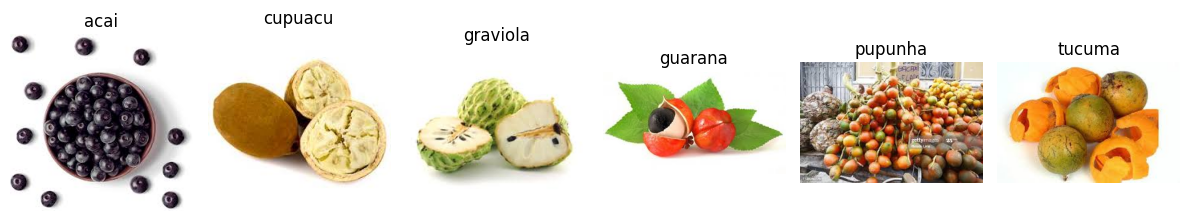

In [ ]:


selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
fig, axes = plt.subplots(1,num_classes, figsize=(12,6))

if num_classes == 1:
    axes = [axes]

for ax, img_path, label in zip(axes, selected_images, selected_labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
img_height = 224
img_width = 224
batch_size = 64

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Normalize datasets
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer="zeros", gamma_initializer="ones")(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    for filters in [64, 128]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer="zeros", gamma_initializer="ones")(x)
        x = LeakyReLU(alpha=0.01)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer="zeros", gamma_initializer="ones")(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer="zeros", gamma_initializer="ones")(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# Build & compile model
model = make_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_29 (LeakyReLU)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 162,374 (634.27 KB)

 Trainable params: 161,158 (629.52 KB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
history = model.fit(
    train_ds,
    epochs=500,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1448 - loss: 2.3326

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 678ms/step - accuracy: 0.1410 - loss: 2.3505 - val_accuracy: 0.1667 - val_loss: 1.7870
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2873 - loss: 1.9208

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - accuracy: 0.2841 - loss: 1.9333 - val_accuracy: 0.2333 - val_loss: 1.7842
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4354 - loss: 1.6294

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step - accuracy: 0.4347 - loss: 1.6330 - val_accuracy: 0.2667 - val_loss: 1.7801
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.3264 - loss: 1.7661 - val_accuracy: 0.2333 - val_loss: 1.7768
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.4399 - loss: 1.4543 - val_accuracy: 0.2333 - val_loss: 1.7736
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4276 - loss: 1.4981

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.4295 - loss: 1.4985 - val_accuracy: 0.3000 - val_loss: 1.7725
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - accuracy: 0.3190 - loss: 1.7603 - val_accuracy: 0.3000 - val_loss: 1.7704
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 0.5505 - loss: 1.2268 - val_accuracy: 0.2000 - val_loss: 1.7670
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.4696 - loss: 1.3569 - val_accuracy: 0.2000 - val_loss: 1.7622
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.4147 - loss: 1.3835 - val_accuracy: 0.1667 - val_loss: 1.7591
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.5779 - loss: 1.2758 - val_accuracy: 0.1667 - val_loss: 1.7560
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.5735 - loss: 1.0935 - val_accuracy: 0.1667 - val_loss: 1.7537
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.6780 - loss: 1.0723 - val_accuracy: 0.2333 - val_loss:

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2333 - loss: 1.7504
Test accuracy: 0.2333
Test loss: 1.7504


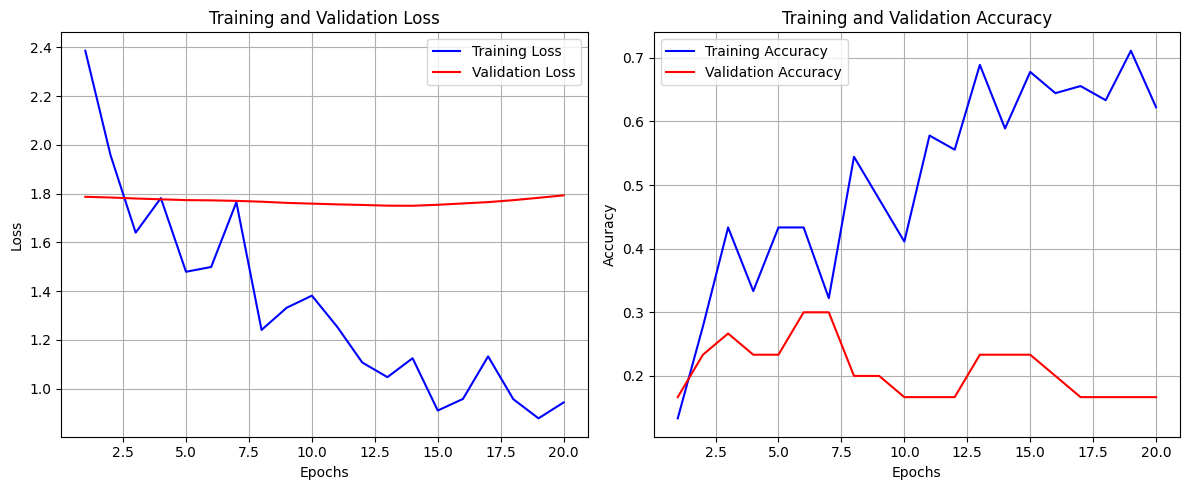

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
model.save('PrajwalGiri_w6_task1.h5')
print("Model saved as 'PrajwalGiri_w6_task1.h5'")

Model saved as 'PrajwalGiri_w6_task1.h5'


In [ ]:

loaded_model = tf.keras.models.load_model('PrajwalGiri_w6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2333 - loss: 1.7504   
Loaded model test accuracy: 0.2333
Loaded model test loss: 1.7504


In [ ]:
loaded_model = keras.models.load_model('PrajwalGiri_w6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.18      1.00      0.30         5
    graviola       0.00      0.00      0.00         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.23        30
   macro avg       0.20      0.23      0.15        30
weighted avg       0.20      0.23      0.15        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=250,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.1826 - loss: 1.9856

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1810 - loss: 1.9926 - val_accuracy: 0.3667 - val_loss: 1.7974
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 935ms/step - accuracy: 0.4986 - loss: 1.6949 - val_accuracy: 0.2333 - val_loss: 1.7848
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2337 - loss: 1.6341 - val_accuracy: 0.3000 - val_loss: 1.6268
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4743 - loss: 1.3953

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 927ms/step - accuracy: 0.4866 - loss: 1.3890 - val_accuracy: 0.4000 - val_loss: 1.5330
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6047 - loss: 1.2885

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.6031 - loss: 1.2862 - val_accuracy: 0.4667 - val_loss: 1.5047
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.6358 - loss: 1.2186 - val_accuracy: 0.3667 - val_loss: 1.4621
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - accuracy: 0.6780 - loss: 1.1402 - val_accuracy: 0.4000 - val_loss: 1.4043
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7038 - loss: 0.9810

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step - accuracy: 0.6988 - loss: 0.9867 - val_accuracy: 0.5000 - val_loss: 1.3782
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - accuracy: 0.8020 - loss: 0.9108 - val_accuracy: 0.5000 - val_loss: 1.4088
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - accuracy: 0.7916 - loss: 0.8766 - val_accuracy: 0.4667 - val_loss: 1.3980
Epoch 11/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - accuracy: 0.8568 - loss: 0.8025 - val_accuracy: 0.5000 - val_loss: 1.3391
Epoch 12/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.8895 - loss: 0.7467 - val_accuracy: 0.4667 - val_loss: 1.3057
Epoch 13/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.8694 - loss: 0.7093 - val_accuracy: 0.5000 - val_loss: 1.2563
Epoch 14/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.8947 - loss: 0.6366 - val_accuracy: 0.5000 - val_loss: 1.2344
Epoch 15/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8953 - loss: 0.6166

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - accuracy: 0.8969 - loss: 0.6123 - val_accuracy: 0.5667 - val_loss: 1.2503
Epoch 16/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8797 - loss: 0.6030

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.8865 - loss: 0.5925 - val_accuracy: 0.6333 - val_loss: 1.2613
Epoch 17/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.9295 - loss: 0.5374 - val_accuracy: 0.6333 - val_loss: 1.2517
Epoch 18/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - accuracy: 0.9347 - loss: 0.4984 - val_accuracy: 0.6000 - val_loss: 1.2192
Epoch 19/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step - accuracy: 0.9147 - loss: 0.4613 - val_accuracy: 0.6000 - val_loss: 1.1890
Epoch 20/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - accuracy: 0.9221 - loss: 0.4450 - val_accuracy: 0.6000 - val_loss: 1.1589
Epoch 21/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - accuracy: 0.9273 - loss: 0.3981 - val_accuracy: 0.5667 - val_loss: 1.1495
Epoch 22/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.9600 - loss: 0.3753 - val_accuracy: 0.5667 - val_loss: 1.1464
Epoch 23/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - accuracy: 0.9622 - loss: 0.3460 - val_accuracy: 0.6000 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - accuracy: 0.9748 - loss: 0.3334 - val_accuracy: 0.6667 - val_loss: 1.1174
Epoch 25/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9733 - loss: 0.3134

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - accuracy: 0.9748 - loss: 0.3122 - val_accuracy: 0.7000 - val_loss: 1.0927
Epoch 26/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step - accuracy: 0.9748 - loss: 0.2954 - val_accuracy: 0.6667 - val_loss: 1.0777
Epoch 27/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step - accuracy: 0.9800 - loss: 0.2723 - val_accuracy: 0.6333 - val_loss: 1.0701
Epoch 28/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step - accuracy: 0.9800 - loss: 0.2541 - val_accuracy: 0.6000 - val_loss: 1.0755
Epoch 29/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - accuracy: 1.0000 - loss: 0.2331 - val_accuracy: 0.5667 - val_loss: 1.0555
Epoch 30/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step - accuracy: 1.0000 - loss: 0.2330 - val_accuracy: 0.6333 - val_loss: 1.0214
Epoch 31/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - accuracy: 1.0000 - loss: 0.2140 - val_accuracy: 0.6667 - val_loss: 0.9850
Epoch 32/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 0.2088

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step - accuracy: 1.0000 - loss: 0.2056 - val_accuracy: 0.7667 - val_loss: 0.9731
Epoch 33/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step - accuracy: 1.0000 - loss: 0.1926 - val_accuracy: 0.7333 - val_loss: 0.9909
Epoch 34/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step - accuracy: 1.0000 - loss: 0.1718 - val_accuracy: 0.6667 - val_loss: 1.0105
Epoch 35/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 1.0000 - loss: 0.1654 - val_accuracy: 0.6667 - val_loss: 1.0247
Epoch 36/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step - accuracy: 1.0000 - loss: 0.1521 - val_accuracy: 0.6333 - val_loss: 1.0168
Epoch 37/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 1.0000 - loss: 0.1557 - val_accuracy: 0.6333 - val_loss: 0.9758


In [ ]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7667 - loss: 0.9731
Test accuracy for VGG16: 0.7667


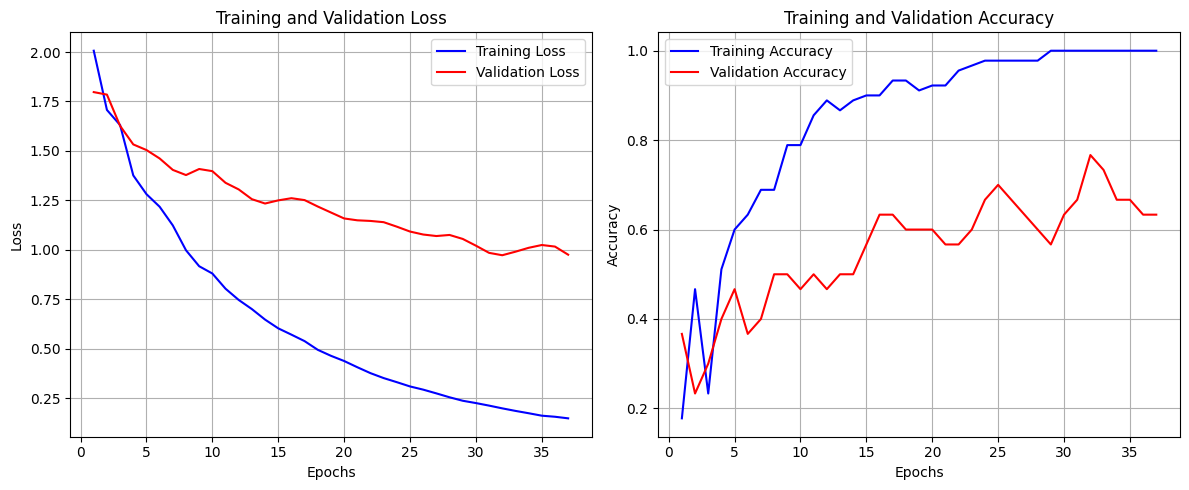

In [ ]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:

predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.67      0.80      0.73         5
     cupuacu       0.67      0.80      0.73         5
    graviola       1.00      0.80      0.89         5
     guarana       1.00      1.00      1.00         5
     pupunha       1.00      0.60      0.75         5
      tucuma       0.50      0.60      0.55         5

    accuracy                           0.77        30
   macro avg       0.81      0.77      0.77        30
weighted avg       0.81      0.77      0.77        30

